
# Drought Prediction Dataset — Statistical Analysis & Preprocessing

This notebook reproduces the full statistical analysis, visualization, preprocessing pipeline, and evaluation protocol you provided — organized into clean, runnable cells.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)


## 1) Load the data

In [3]:

# Load the data
df = pd.read_csv('../data/generated_data/fips_6107_drought_features.csv')
df['date'] = pd.to_datetime(df['date'])

print("="*80)
print("DROUGHT PREDICTION DATASET - STATISTICAL ANALYSIS")
print("="*80)


DROUGHT PREDICTION DATASET - STATISTICAL ANALYSIS


## 2) Descriptive statistics

In [4]:

# ============================================================================
# 1. DESCRIPTIVE STATISTICS
# ============================================================================
print("\n" + "="*80)
print("1. DESCRIPTIVE STATISTICS")
print("="*80)

print(f"\nDataset Shape: {df.shape[0]} observations × {df.shape[1]} features")
print(f"Date Range: {df['date'].min()} to {df['date'].max()}")
print(f"Duration: {(df['date'].max() - df['date'].min()).days} days")

# Separate features and target
feature_cols = [col for col in df.columns if col not in ['fips', 'date', 'score']]
X = df[feature_cols]
y = df['score']

print(f"\nNumber of Features: {len(feature_cols)}")
print(f"Target Variable (score) - Non-null values: {y.notna().sum()}")

# Summary statistics
print("\n--- Target Variable (Drought Score) Statistics ---")
print(y.describe())

print("\n--- Features Statistics (Selected) ---")
# Show statistics for key features
key_features = ['prec_sum_7d', 'prec_sum_30d', 't2m_mean_7d', 't2m_mean_30d', 
                'qv2m_mean_7d', 'ws10m_mean_7d', 'ps_mean_7d']
print(df[key_features].describe().T)

# Check for missing values
print("\n--- Missing Values Analysis ---")
missing_counts = df.isnull().sum()
if missing_counts.sum() > 0:
    print("\nFeatures with missing values:")
    print(missing_counts[missing_counts > 0].sort_values(ascending=False))
else:
    print("No missing values found in the dataset.")



1. DESCRIPTIVE STATISTICS

Dataset Shape: 887 observations × 62 features
Date Range: 2000-01-04 00:00:00 to 2016-12-27 00:00:00
Duration: 6202 days

Number of Features: 59
Target Variable (score) - Non-null values: 887

--- Target Variable (Drought Score) Statistics ---
count    887.000000
mean       1.879185
std        1.785176
min        0.000000
25%        0.000000
50%        1.594700
75%        3.000000
max        5.000000
Name: score, dtype: float64

--- Features Statistics (Selected) ---
               count       mean        std        min        25%        50%  \
prec_sum_7d    887.0   6.965750  14.721634   0.000000   0.050000   0.790000   
prec_sum_30d   887.0  29.473529  37.605602   0.000000   3.200000  13.180000   
t2m_mean_7d    887.0  12.822074   7.609340  -2.605714   6.596429  11.647143   
t2m_mean_30d   887.0  12.820572   7.141023   0.224000   6.285667  11.640000   
qv2m_mean_7d   887.0   4.476602   1.255631   1.422857   3.602857   4.395714   
ws10m_mean_7d  887.0   2.2

## 3) Outlier detection (IQR method)

In [5]:

# ============================================================================
# 2. OUTLIER DETECTION
# ============================================================================
print("\n" + "="*80)
print("2. OUTLIER DETECTION (IQR Method)")
print("="*80)

def detect_outliers_iqr(data, feature):
    """Detect outliers using IQR method"""
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
    return outliers, lower_bound, upper_bound

outlier_summary = []
for col in feature_cols[:20]:  # Check first 20 features
    n_outliers, lb, ub = detect_outliers_iqr(df, col)
    if n_outliers > 0:
        outlier_summary.append({
            'Feature': col,
            'N_Outliers': n_outliers,
            'Percentage': f"{(n_outliers/len(df)*100):.2f}%",
            'Lower_Bound': f"{lb:.2f}",
            'Upper_Bound': f"{ub:.2f}"
        })

if outlier_summary:
    print(pd.DataFrame(outlier_summary).to_string(index=False))
else:
    print("No significant outliers detected in the first 20 features.")



2. OUTLIER DETECTION (IQR Method)
          Feature  N_Outliers Percentage Lower_Bound Upper_Bound
      prec_sum_7d         120     13.53%       -9.92       16.66
     prec_sum_30d          35      3.95%      -56.57      102.82
     prec_sum_90d          15      1.69%     -150.30      306.74
    prec_sum_180d          13      1.47%     -176.70      497.58
t2m_range_mean_7d           2      0.23%        6.12       20.47


## 4) Correlation analysis

In [6]:

# ============================================================================
# 3. CORRELATION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("3. CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation with target
correlations = df[feature_cols].corrwith(y).sort_values(ascending=False)
print("\n--- Top 10 Features Correlated with Drought Score ---")
print(correlations.head(10))
print("\n--- Bottom 10 Features Correlated with Drought Score ---")
print(correlations.tail(10))



3. CORRELATION ANALYSIS

--- Top 10 Features Correlated with Drought Score ---
t2m_range_mean_180d    0.203747
t2m_max_mean_180d      0.174711
vpd_proxy_30d          0.173498
t2m_range_mean_90d     0.161382
t2m_mean_180d          0.161044
t2m_min_mean_180d      0.159885
t2m_max_mean_90d       0.148838
vpd_proxy_7d           0.142134
t2m_min_mean_90d       0.140207
t2m_mean_90d           0.139145
dtype: float64

--- Bottom 10 Features Correlated with Drought Score ---
prec_sum_7d          -0.090178
ws10m_min_mean_7d    -0.105400
ws50m_max_30d        -0.121307
ws50m_min_mean_7d    -0.125106
ws50m_mean_30d       -0.132012
prec_sum_30d         -0.179304
ws10m_min_mean_30d   -0.190976
ws50m_min_mean_30d   -0.227261
prec_sum_90d         -0.271054
prec_sum_180d        -0.345815
dtype: float64


## 5) Feature distribution analysis

In [7]:

# ============================================================================
# 4. FEATURE DISTRIBUTION ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("4. FEATURE DISTRIBUTION ANALYSIS")
print("="*80)

# Check skewness
skewness = df[feature_cols].skew().sort_values(ascending=False)
print("\n--- Most Skewed Features (|skewness| > 1) ---")
highly_skewed = skewness[abs(skewness) > 1]
if len(highly_skewed) > 0:
    print(highly_skewed)
else:
    print("No highly skewed features found.")



4. FEATURE DISTRIBUTION ANALYSIS

--- Most Skewed Features (|skewness| > 1) ---
prec_sum_7d           4.704909
prec_deficit_7v30d    2.933109
prec_sum_30d          2.388603
ws50m_max_7d          1.395077
ws50m_min_mean_7d     1.377919
ws10m_max_30d         1.346357
prec_sum_90d          1.194264
ws50m_max_30d         1.067083
prec_sum_180d         1.033019
dtype: float64


## 6) Visualizations


5. GENERATING VISUALIZATIONS
✓ Visualization saved as 'drought_statistical_analysis.png'


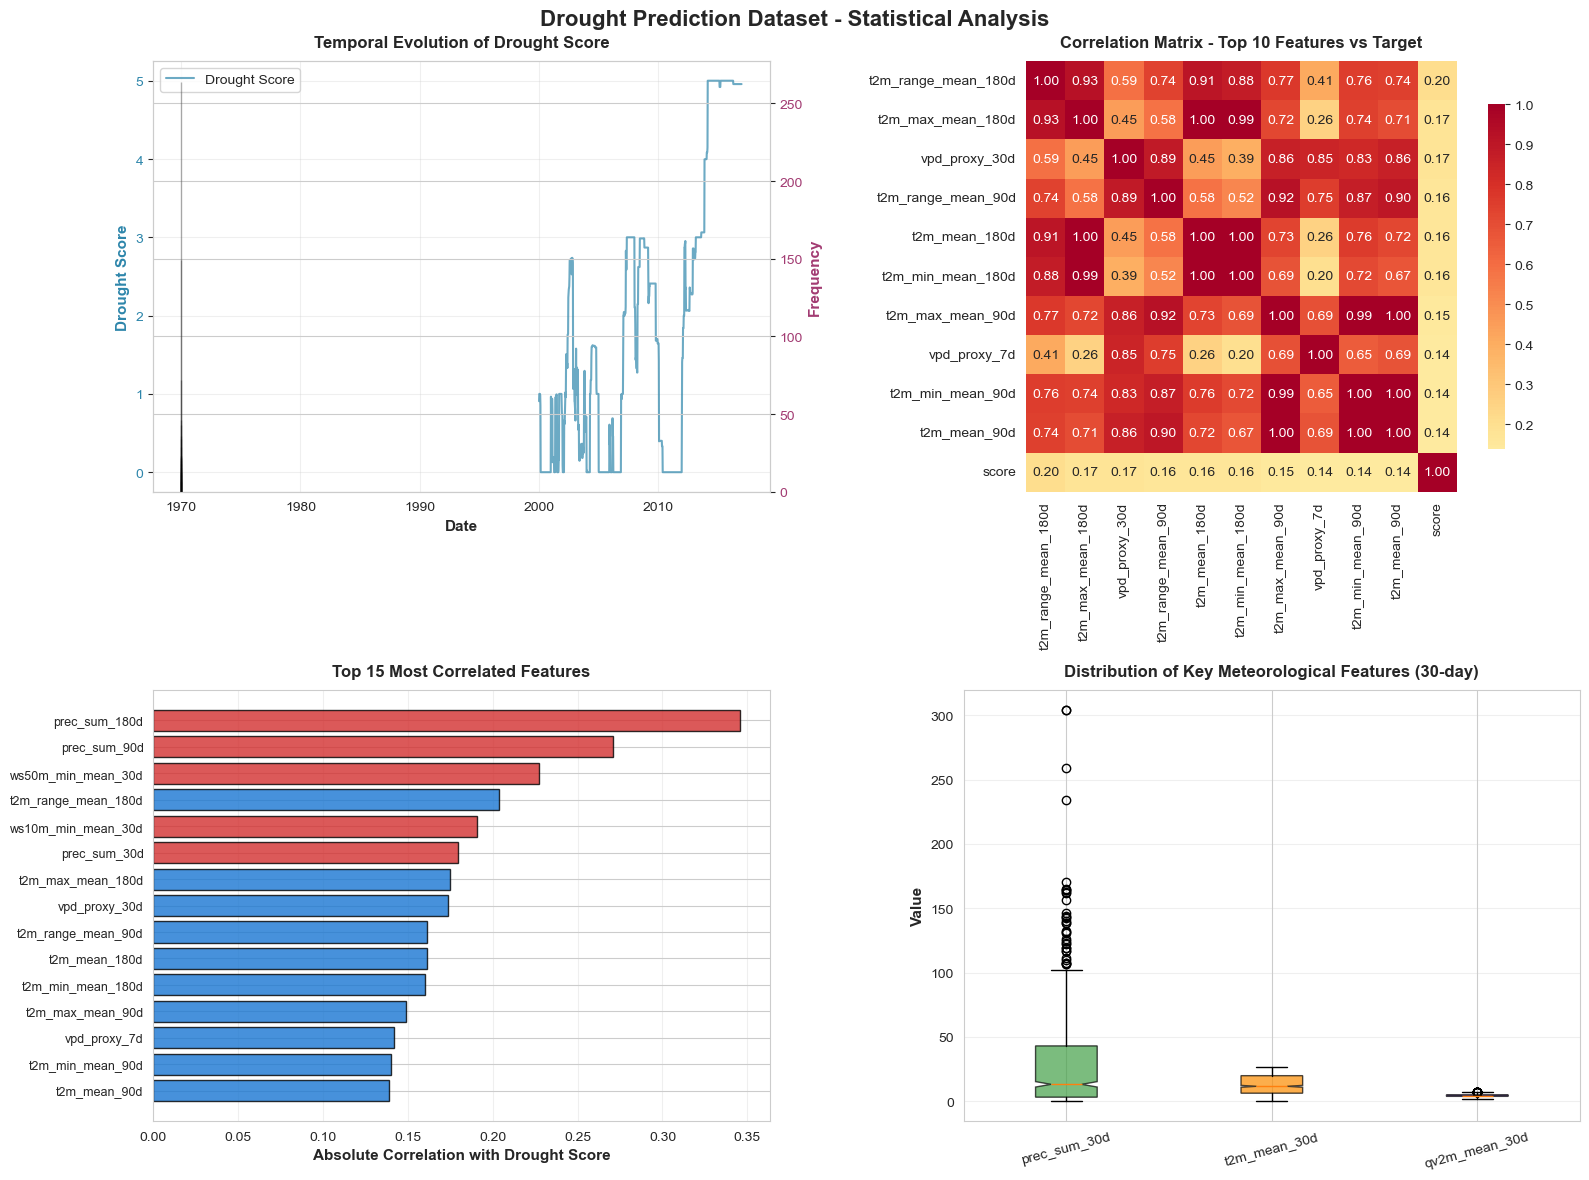

In [8]:

# ============================================================================
# 5. VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("5. GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Drought Prediction Dataset - Statistical Analysis', fontsize=16, fontweight='bold')

# Figure 1: Target Distribution and Temporal Evolution
ax1 = axes[0, 0]
ax1_twin = ax1.twinx()
ax1.plot(df['date'], y, linewidth=1.5, color='#2E86AB', alpha=0.7, label='Drought Score')
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Drought Score', fontsize=11, fontweight='bold', color='#2E86AB')
ax1.tick_params(axis='y', labelcolor='#2E86AB')
ax1.grid(True, alpha=0.3)
ax1.set_title('Temporal Evolution of Drought Score', fontsize=12, fontweight='bold', pad=10)
ax1.legend(loc='upper left')

# Add histogram on twin axis
ax1_twin.hist(y.dropna(), bins=30, alpha=0.3, color='#A23B72', edgecolor='black')
ax1_twin.set_ylabel('Frequency', fontsize=11, fontweight='bold', color='#A23B72')
ax1_twin.tick_params(axis='y', labelcolor='#A23B72')

# Figure 2: Correlation Heatmap (Top Features)
ax2 = axes[0, 1]
top_features = correlations.head(10).index.tolist()
corr_matrix = df[top_features + ['score']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Correlation Matrix - Top 10 Features vs Target', fontsize=12, fontweight='bold', pad=10)

# Figure 3: Feature Importance (Absolute Correlation)
ax3 = axes[1, 0]
top_15_corr = correlations.abs().sort_values(ascending=True).tail(15)
colors = ['#D32F2F' if x < 0 else '#1976D2' for x in correlations[top_15_corr.index]]
ax3.barh(range(len(top_15_corr)), top_15_corr.values, color=colors, edgecolor='black', alpha=0.8)
ax3.set_yticks(range(len(top_15_corr)))
ax3.set_yticklabels(top_15_corr.index, fontsize=9)
ax3.set_xlabel('Absolute Correlation with Drought Score', fontsize=11, fontweight='bold')
ax3.set_title('Top 15 Most Correlated Features', fontsize=12, fontweight='bold', pad=10)
ax3.grid(axis='x', alpha=0.3)

# Figure 4: Distribution of Key Features
ax4 = axes[1, 1]
key_feature_viz = ['prec_sum_30d', 't2m_mean_30d', 'qv2m_mean_30d']
positions = range(len(key_feature_viz))
bp = ax4.boxplot([df[col].dropna() for col in key_feature_viz],
                  labels=key_feature_viz,
                  patch_artist=True,
                  notch=True,
                  showfliers=True)
for patch, color in zip(bp['boxes'], ['#43A047', '#FB8C00', '#5E35B1']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Key Meteorological Features (30-day)', fontsize=12, fontweight='bold', pad=10)
ax4.tick_params(axis='x', rotation=15)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('drought_statistical_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved as 'drought_statistical_analysis.png'")


## 7) Preprocessing pipeline — justification

In [9]:

# ============================================================================
# 6. PREPROCESSING JUSTIFICATION & IMPLEMENTATION
# ============================================================================
print("\n" + "="*80)
print("6. PREPROCESSING PIPELINE")
print("="*80)

print("\n--- Preprocessing Steps Justification ---")
print("""
1. HANDLING MISSING VALUES:
   - Strategy: Remove rows with missing target (score) values
   - Rationale: Cannot train on samples without labels
   - For features: Use forward-fill for time-series continuity

2. OUTLIER MANAGEMENT:
   - Strategy: Use RobustScaler instead of removing outliers
   - Rationale: Extreme weather events are informative for drought prediction
   - RobustScaler uses median and IQR, making it robust to outliers

3. FEATURE SCALING:
   - Strategy: RobustScaler for all features
   - Rationale: Features have different scales (e.g., precipitation vs temperature)
   - RobustScaler chosen over StandardScaler due to presence of outliers

4. TEMPORAL ORDERING:
   - Strategy: Maintain chronological order in train/test split
   - Rationale: Avoid data leakage in time-series prediction

5. FEATURE ENGINEERING:
   - Already completed: Rolling windows, deficits, anomalies
   - Rationale: Capture temporal patterns relevant to drought development
""")



6. PREPROCESSING PIPELINE

--- Preprocessing Steps Justification ---

1. HANDLING MISSING VALUES:
   - Strategy: Remove rows with missing target (score) values
   - Rationale: Cannot train on samples without labels
   - For features: Use forward-fill for time-series continuity

2. OUTLIER MANAGEMENT:
   - Strategy: Use RobustScaler instead of removing outliers
   - Rationale: Extreme weather events are informative for drought prediction
   - RobustScaler uses median and IQR, making it robust to outliers

3. FEATURE SCALING:
   - Strategy: RobustScaler for all features
   - Rationale: Features have different scales (e.g., precipitation vs temperature)
   - RobustScaler chosen over StandardScaler due to presence of outliers

4. TEMPORAL ORDERING:
   - Strategy: Maintain chronological order in train/test split
   - Rationale: Avoid data leakage in time-series prediction

5. FEATURE ENGINEERING:
   - Already completed: Rolling windows, deficits, anomalies
   - Rationale: Capture temporal 

In [10]:

# Remove rows with missing target
df_clean = df.dropna(subset=['score']).copy()
print(f"\nRows after removing missing targets: {len(df_clean)} (removed {len(df) - len(df_clean)})")

# Handle missing features (forward fill for time series)
for col in feature_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')

print(f"Missing values after preprocessing: {df_clean[feature_cols].isnull().sum().sum()}")

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean[feature_cols])
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)

print("\n✓ Feature scaling completed using RobustScaler")
print(f"Scaled features shape: {X_scaled_df.shape}")



Rows after removing missing targets: 887 (removed 0)
Missing values after preprocessing: 0

✓ Feature scaling completed using RobustScaler
Scaled features shape: (887, 59)


## 8) Evaluation protocol for machine learning

In [11]:

# ============================================================================
# 7. EVALUATION PROTOCOL
# ============================================================================
print("\n" + "="*80)
print("7. EVALUATION PROTOCOL FOR MACHINE LEARNING")
print("="*80)

print("""
PROTOCOL DESIGN:
───────────────

A. DATA SPLITTING STRATEGY (Time-Series Split):
   • Method: TimeSeriesSplit with 5 folds
   • Rationale: Preserves temporal ordering to prevent data leakage
   • Training set: First 70% of chronological data
   • Validation set: Next 15% (for hyperparameter tuning)
   • Test set: Final 15% (for final model evaluation)

   Time-Series Split ensures:
   - No future information leaks into training
   - Realistic evaluation (predicting future droughts)
   - Models learn temporal patterns correctly

B. HYPERPARAMETER TUNING:
   • Method: Time-Series Cross-Validation (5 folds)
   • Search: Grid Search or Randomized Search
   • Validation metric: RMSE (primary) + R² (secondary)
   • Process: Tune on training + validation, evaluate on held-out test set

C. MODEL COMPARISON:
   • Test multiple algorithms on same train/validation/test splits
   • Compare using consistent metrics
   • Statistical significance testing (paired t-test on CV folds)

EVALUATION METRICS (3 Selected):
────────────────────────────────

1. ROOT MEAN SQUARED ERROR (RMSE):
   • Primary metric for model selection
   • Penalizes large errors (critical for severe droughts)
   • Same units as target variable (interpretable)
   • Formula: √(Σ(y_true - y_pred)²/n)

2. R² SCORE (Coefficient of Determination):
   • Measures proportion of variance explained
   • Range: -∞ to 1 (1 = perfect prediction)
   • Useful for comparing model performance
   • Formula: 1 - (SS_res / SS_tot)

3. MEAN ABSOLUTE ERROR (MAE):
   • Robust to outliers (linear penalty)
   • Interpretable: average prediction error
   • Complements RMSE for comprehensive evaluation
   • Formula: Σ|y_true - y_pred|/n

RATIONALE FOR METRIC SELECTION:
• RMSE: Main optimization target (sensitive to large errors)
• R²: Overall model fit quality
• MAE: Robust average error (less sensitive to outliers)
""")



7. EVALUATION PROTOCOL FOR MACHINE LEARNING

PROTOCOL DESIGN:
───────────────

A. DATA SPLITTING STRATEGY (Time-Series Split):
   • Method: TimeSeriesSplit with 5 folds
   • Rationale: Preserves temporal ordering to prevent data leakage
   • Training set: First 70% of chronological data
   • Validation set: Next 15% (for hyperparameter tuning)
   • Test set: Final 15% (for final model evaluation)

   Time-Series Split ensures:
   - No future information leaks into training
   - Realistic evaluation (predicting future droughts)
   - Models learn temporal patterns correctly

B. HYPERPARAMETER TUNING:
   • Method: Time-Series Cross-Validation (5 folds)
   • Search: Grid Search or Randomized Search
   • Validation metric: RMSE (primary) + R² (secondary)
   • Process: Tune on training + validation, evaluate on held-out test set

C. MODEL COMPARISON:
   • Test multiple algorithms on same train/validation/test splits
   • Compare using consistent metrics
   • Statistical significance testing

In [12]:

# Implement the splitting
print("\n--- Implementing Data Split ---")

# Sort by date
df_clean = df_clean.sort_values('date').reset_index(drop=True)
X_final = X_scaled_df.values
y_final = df_clean['score'].values
dates = df_clean['date'].values

# Calculate split indices
n = len(df_clean)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X_final[:train_end]
y_train = y_final[:train_end]
dates_train = dates[:train_end]

X_val = X_final[train_end:val_end]
y_val = y_final[train_end:val_end]
dates_val = dates[train_end:val_end]

X_test = X_final[val_end:]
y_test = y_final[val_end:]
dates_test = dates[val_end:]

print(f"\nTraining set:   {len(X_train)} samples ({len(X_train)/n*100:.1f}%)")
print(f"                Date range: {dates_train[0]} to {dates_train[-1]}")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/n*100:.1f}%)")
print(f"                Date range: {dates_val[0]} to {dates_val[-1]}")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/n*100:.1f}%)")
print(f"                Date range: {dates_test[0]} to {dates_test[-1]}")

# Setup Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
print(f"\n✓ Time-Series Cross-Validation configured: {tscv.n_splits} folds")
print("  Each fold respects temporal ordering for validation")

# Save preprocessed data
np.savez('drought_preprocessed_data.npz',
         X_train=X_train, y_train=y_train, dates_train=dates_train,
         X_val=X_val, y_val=y_val, dates_val=dates_val,
         X_test=X_test, y_test=y_test, dates_test=dates_test,
         feature_names=feature_cols)

df_clean.to_csv('drought_cleaned_data.csv', index=False)

print("\n✓ Preprocessed data saved:")
print("  - 'drought_preprocessed_data.npz' (train/val/test splits)")
print("  - 'drought_cleaned_data.csv' (cleaned dataset)")



--- Implementing Data Split ---

Training set:   620 samples (69.9%)
                Date range: 2000-01-04T00:00:00.000000000 to 2011-11-15T00:00:00.000000000
Validation set: 133 samples (15.0%)
                Date range: 2011-11-22T00:00:00.000000000 to 2014-06-03T00:00:00.000000000
Test set:       134 samples (15.1%)
                Date range: 2014-06-10T00:00:00.000000000 to 2016-12-27T00:00:00.000000000

✓ Time-Series Cross-Validation configured: 5 folds
  Each fold respects temporal ordering for validation

✓ Preprocessed data saved:
  - 'drought_preprocessed_data.npz' (train/val/test splits)
  - 'drought_cleaned_data.csv' (cleaned dataset)


## 9) Summary for report

In [13]:

# ============================================================================
# 8. SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "="*80)
print("8. SUMMARY FOR REPORT")
print("="*80)

summary_stats = {
    'Metric': ['Total Observations', 'Training Samples', 'Validation Samples', 
               'Test Samples', 'Number of Features', 'Date Range (days)',
               'Target Mean', 'Target Std', 'Target Min', 'Target Max'],
    'Value': [n, len(X_train), len(X_val), len(X_test), len(feature_cols),
              (df_clean['date'].max() - df_clean['date'].min()).days,
              f"{y_final.mean():.3f}", f"{y_final.std():.3f}",
              f"{y_final.min():.3f}", f"{y_final.max():.3f}"]
}

print("\n", pd.DataFrame(summary_stats).to_string(index=False))

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nNext Steps:")
print("1. Review the generated figure 'drought_statistical_analysis.png'")
print("2. Use the preprocessed data for model training")
print("3. Implement machine learning models with the defined evaluation protocol")
print("4. Compare models using RMSE, R², and MAE metrics")



8. SUMMARY FOR REPORT

             Metric Value
Total Observations   887
  Training Samples   620
Validation Samples   133
      Test Samples   134
Number of Features    59
 Date Range (days)  6202
       Target Mean 1.879
        Target Std 1.784
        Target Min 0.000
        Target Max 5.000

ANALYSIS COMPLETE

Next Steps:
1. Review the generated figure 'drought_statistical_analysis.png'
2. Use the preprocessed data for model training
3. Implement machine learning models with the defined evaluation protocol
4. Compare models using RMSE, R², and MAE metrics
